In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras

from keras.datasets import mnist
from keras.utils import to_categorical

from keras import models
from keras import layers

from keras import losses, optimizers, metrics

C:\Users\bikas\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.preprocessing.image import ImageDataGenerator
train_dir = 'data\\train'
test_dir = 'data\\test'

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10.,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(224, 224), 
    batch_size=32
)

test_generator = test_datagen.flow_from_directory(
    test_dir, 
    target_size=(224, 224), 
    batch_size=32
)

Found 9410 images belonging to 2 classes.
Found 366 images belonging to 2 classes.


## Try using pretrined model

In [3]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(224, 224, 3))
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [4]:
model = models.Sequential()

model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1026      
Total params: 27,561,282
Trainable params: 27,561,282
Non-trainable params: 0
_________________________________________________________________


In [5]:
conv_base.trainable = False
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))

model.compile(
    optimizer=optimizers.Adam(lr=5e-5), 
    loss=losses.categorical_crossentropy, 
    metrics=[metrics.categorical_accuracy]
)

history = model.fit_generator(train_generator, 
                              steps_per_epoch=300, 
                              epochs=1, 
                              validation_data=test_generator, 
                              validation_steps=12)

This is the number of trainable weights before freezing the conv base: 4
Epoch 1/1
  1/300 [..............................] - ETA: 21:03 - loss: 0.7895 - categorical_accuracy: 0.4375

C:\Users\bikas\Anaconda3\lib\site-packages\PIL\Image.py:918: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


106/300 [=========>....................] - ETA: 1:37 - loss: 0.1328 - categorical_accuracy: 0.9511

C:\Users\bikas\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))


300/300 [==============================] - 154s 514ms/step - loss: 0.0712 - categorical_accuracy: 0.9744 - val_loss: 0.0559 - val_categorical_accuracy: 0.9754


In [6]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [7]:
from keras.models import load_model
try:
    model = load_model('checkpoints\\model.h5')
except:
    pass

In [8]:
model.compile(
    optimizer=optimizers.Adam(lr=1e-5), 
    loss=losses.categorical_crossentropy, 
    metrics=[metrics.categorical_accuracy]
)

history = model.fit_generator(train_generator, 
                              steps_per_epoch=300, 
                              epochs=10, 
                               callbacks=[
                                  keras.callbacks.ModelCheckpoint('checkpoints\\model.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1),
                                  keras.callbacks.TensorBoard(log_dir='logs\\inception', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None),
                              ],
                              validation_data=test_generator, 
                              validation_steps=12)

Epoch 1/10
 42/300 [===>..........................] - ETA: 2:06 - loss: 9.4602e-05 - categorical_accuracy: 1.0000

C:\Users\bikas\Anaconda3\lib\site-packages\PIL\Image.py:918: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


 76/300 [======>.......................] - ETA: 1:45 - loss: 1.1781e-04 - categorical_accuracy: 1.0000

C:\Users\bikas\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))


300/300 [==============================] - 142s 473ms/step - loss: 1.8389e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0489 - val_categorical_accuracy: 0.9918
Epoch 2/10
300/300 [==============================] - 142s 475ms/step - loss: 0.0017 - categorical_accuracy: 0.9994 - val_loss: 0.0945 - val_categorical_accuracy: 0.9863
Epoch 3/10
300/300 [==============================] - 143s 478ms/step - loss: 0.0022 - categorical_accuracy: 0.9992 - val_loss: 0.0356 - val_categorical_accuracy: 0.9918
Epoch 4/10
300/300 [==============================] - 147s 488ms/step - loss: 2.1465e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0376 - val_categorical_accuracy: 0.9945
Epoch 5/10
300/300 [==============================] - 146s 487ms/step - loss: 2.1548e-04 - categorical_accuracy: 0.9999 - val_loss: 0.0523 - val_categorical_accuracy: 0.9918
Epoch 6/10
300/300 [==============================] - 143s 476ms/step - loss: 6.5111e-04 - categorical_accuracy: 0.9997 - val_loss: 0.0404 - val_cate

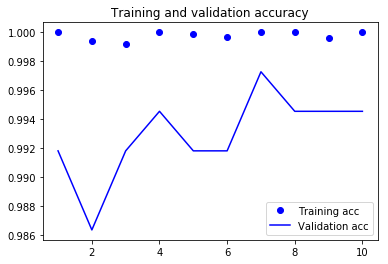

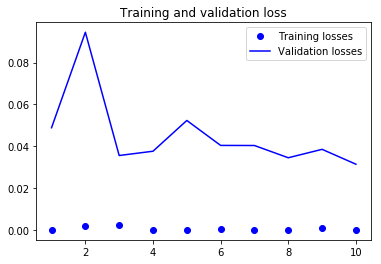

In [9]:
import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training losses')
plt.plot(epochs, val_loss, 'b', label='Validation losses')
plt.title('Training and validation loss')
plt.legend()

plt.show()